# Population by commune

In [1]:
from pynsee.geodata import get_geodata_list, get_geodata, GeoFrDataFrame

import math
import geopandas as gpd
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes

In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [3]:
# get geographical data list
geodata_list = get_geodata_list()
# get departments geographical limits
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/2ac583be54e866b2b1b30fb0113c1fd0
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/a4f589755961ab3aa6bdff99605334d1
Set update=True to get the most up-to-date data


In [4]:
mapcom = gpd.GeoDataFrame(com).set_crs("EPSG:3857")

mapcom = mapcom.to_crs(epsg=3035)
mapcom["area"] = mapcom['geometry'].area / 10**6
mapcom = mapcom.to_crs(epsg=3857)

mapcom['REF_AREA'] = 'D' + mapcom['insee_dep']
mapcom['density'] = mapcom['population'] / mapcom['area'] 

In [5]:
mapcom = GeoFrDataFrame(mapcom)
mapcom = mapcom.translate(departement = ['971', '972', '974', '973', '976'], 
                          factor = [1.5, 1.5, 1.5, 0.35, 1.5])

In [6]:
mapcom = mapcom.zoom(departement = ["75","92", "93", "91", "77", "78", "95", "94"],
                     factor=1.5, startAngle = math.pi * (1 - 3 * 1/9))
mapcom

,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,bbox,crsCoord,area,REF_AREA,density
0,COMMUNE_0000001169858680,Basse-Terre,BASSE-TERRE,97105,Préfecture de région,9892,06,1,971,01,249710070,MULTIPOLYGON (((-750724.8169219699 6268681.730...,"[-6873564.10795631, 1803062.14507434, -6869802...",EPSG:3857,4.472072,D971,2211.950239
1,COMMUNE_0000001169858685,Saint-Claude,SAINT-CLAUDE,97124,Commune simple,10506,06,1,971,01,249710070,MULTIPOLYGON (((-747693.5502122547 6266066.185...,"[-6871849.64839863, 1804329.75663203, -6863926...",EPSG:3857,34.403608,D971,305.374943
2,COMMUNE_0000001169858684,Capesterre-Belle-Eau,CAPESTERRE-BELLE-EAU,97107,Commune simple,17628,07,1,971,01,249710070,MULTIPOLYGON (((-742954.5199814234 6282205.684...,"[-6866643.13408756, 1803123.47210352, -6852304...",EPSG:3857,103.037919,D971,171.082648
3,COMMUNE_0000001169858692,Capesterre-de-Marie-Galante,CAPESTERRE-DE-MARIE-GALANTE,97108,Commune simple,3247,10,2,971,01,249710047,MULTIPOLYGON (((-666227.3979513757 6260492.339...,"[-6819904.02215333, 1789762.25363456, -6812187...",EPSG:3857,46.124250,D971,70.396809
4,COMMUNE_0000001169858666,Saint-Louis,SAINT-LOUIS,97126,Commune simple,2462,10,2,971,01,249710047,MULTIPOLYGON (((-666227.3979513757 6260492.339...,"[-6826466.0858777, 1795861.91154973, -6815342....",EPSG:3857,57.347426,D971,42.931308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36208,COMMUNE_0000000009734470,Dhuisy,DHUISY,77157,Commune simple,317,06,1,77,11,247700065,MULTIPOLYGON (((-351625.76655622484 6618194.16...,"[349321.12599156, 6276714.73065152, 355190.946...",EPSG:3857,8.149347,D77,38.898824
36209,COMMUNE_0000000009734981,Mary-sur-Marne,MARY-SUR-MARNE,77280,Commune simple,1095,06,1,77,11,247700065,MULTIPOLYGON (((-373298.8244794502 6618451.969...,"[335409.61945441, 6276030.38893351, 339858.746...",EPSG:3857,2.233051,D77,490.360507
36210,COMMUNE_0000000009734468,Vendrest,VENDREST,77490,Commune simple,689,06,1,77,11,247700065,MULTIPOLYGON (((-361891.457866755 6622609.1719...,"[341330.98775089, 6278825.84895588, 350904.847...",EPSG:3857,17.692283,D77,38.943532
36211,COMMUNE_0000000009734980,Ocquerre,OCQUERRE,77343,Commune simple,386,06,1,77,11,247700065,MULTIPOLYGON (((-364995.7685882246 6618752.634...,"[337038.06572493, 6277160.42905055, 343734.463...",EPSG:3857,10.165914,D77,37.970024


In [7]:
mapplot = gpd.GeoDataFrame(mapcom)
mapplot.loc[mapplot.density < 40, 'range'] = "< 40"
mapplot.loc[mapplot.density >= 20000, 'range'] = "> 20 000"

density_ranges = [40, 80, 100, 120, 150, 200, 250, 400, 600, 1000, 2000, 5000, 10000, 20000]
list_ranges = []
list_ranges.append( "< 40")

for i in range(len(density_ranges)-1):
    min_range = density_ranges[i]
    max_range = density_ranges[i+1]
    range_string = "[{}, {}[".format(min_range, max_range)
    mapplot.loc[(mapplot.density >= min_range) & (mapplot.density < max_range), 'range'] = range_string
    list_ranges.append(range_string)

list_ranges.append("> 20 000")

mapplot['range'] = mapplot['range'].astype(CategoricalDtype(categories=list_ranges, ordered=True))  

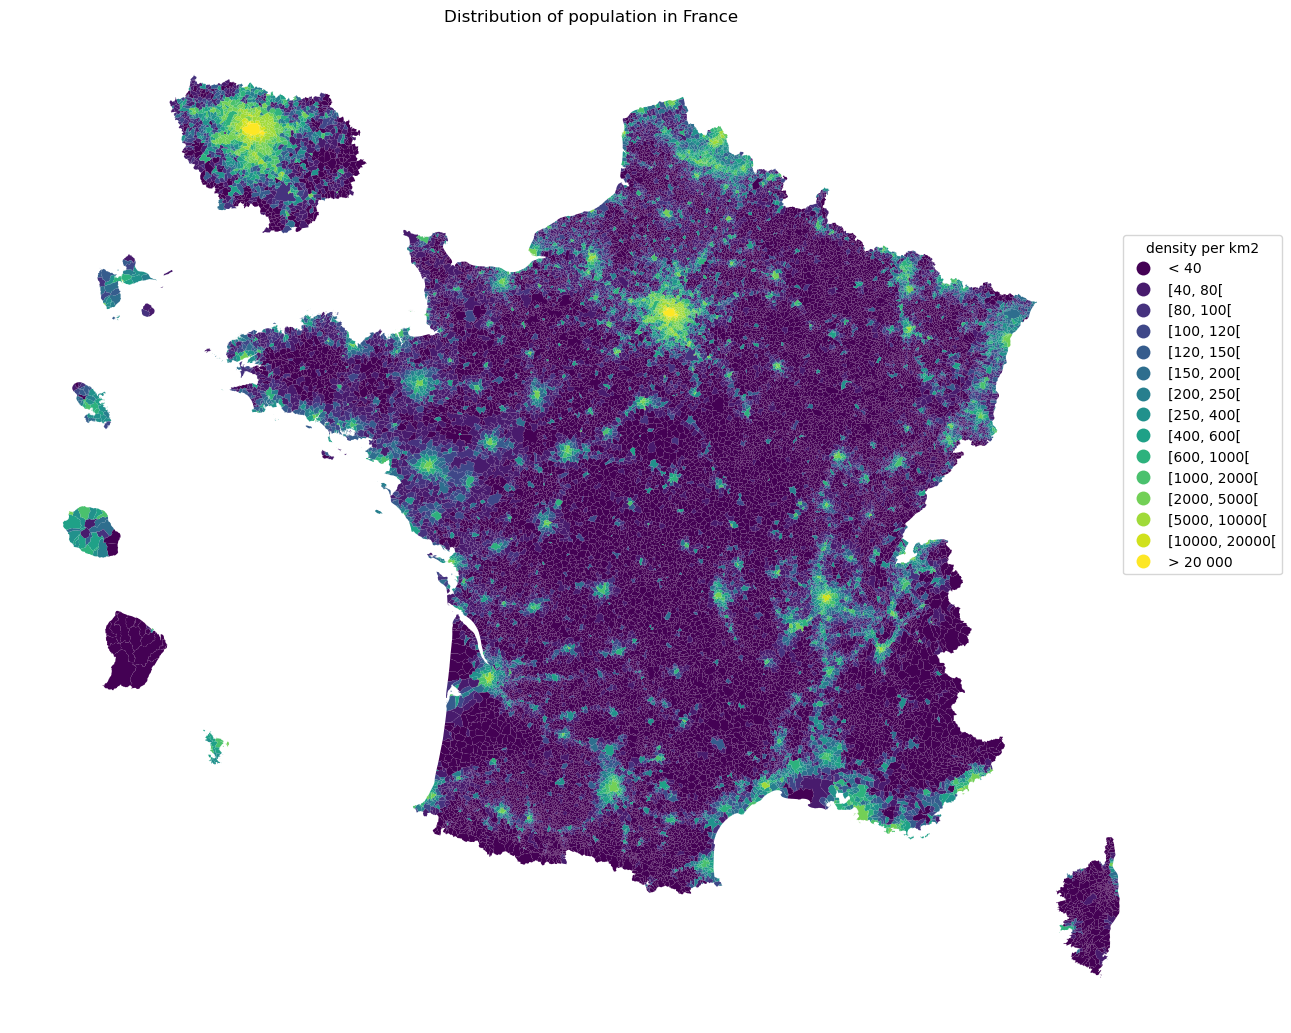

In [8]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
mapplot.plot(column='range', cmap=cm.viridis,
    legend=True, ax=ax,
    legend_kwds={'bbox_to_anchor': (1.1, 0.8),
                 'title':'density per km2'})
ax.set_axis_off()
ax.set(title='Distribution of population in France')
plt.show()

fig.savefig('pop_france.svg',
            format='svg', dpi=1200,
            bbox_inches = 'tight',
            pad_inches = 0)